In [1]:
import numpy as np
# import seaborn as sns
import pandas as pd
import os.path

import matplotlib.pyplot as plt

import tifffile 
import czifile

from skimage import transform
from scipy import ndimage

import random 
import math

In [2]:
from skimage.registration import optical_flow_tvl1


In [3]:
movie_dir =  '/mnt/d/lding/actomyosin/data/data_Wenhong'



movie_name = 'VidS1.tif'
patch_size = 32


####################
root_processed_data_dir = '/mnt/d/lding/actomyosin/data/processed_data'
root_partitioned_data_dir = '/mnt/d/lding/actomyosin/data/partitioned_data_wenhong_flow'
root_plot_dir = '/mnt/d/lding/actomyosin/analysis_results'

processed_data_dir =  os.path.join(root_processed_data_dir, movie_name)

partitioned_data_dir =  os.path.join(root_partitioned_data_dir, movie_name+'_patchsize_'+str(patch_size))
plot_dir =  os.path.join(root_plot_dir, movie_name+'_flows2_thp1_ps'+str(patch_size))

if not os.path.isdir(processed_data_dir):
    os.makedirs(processed_data_dir)
if not os.path.isdir(partitioned_data_dir):
    os.makedirs(partitioned_data_dir)
if not os.path.isdir(plot_dir):
    os.makedirs(plot_dir)



In [4]:
def rotate_coor(x_i,y_i,x_c,y_c,rotate_angle):
 
    rotate_angle = rotate_angle*np.pi/180
 
    x_o = (x_i-x_c)*math.cos(rotate_angle) - (2*y_c-y_i-y_c)*math.sin(rotate_angle) +x_c
    y_o = -(x_i-x_c)*math.sin(rotate_angle) - (2*y_c-y_i-y_c)*math.cos(rotate_angle) +(2*y_c-y_c)

    return([x_o,y_o])

In [5]:
import matplotlib as mpl

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/lding/anaconda3/envs/aics_segmentation/lib/python3.6/site-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
/home/lding/anaconda3/envs/aics_segmentation/lib/python3.6/site-packages/ipykernel_launcher.py:92: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("hsv"))
/home/ld

KeyboardInterrupt: 

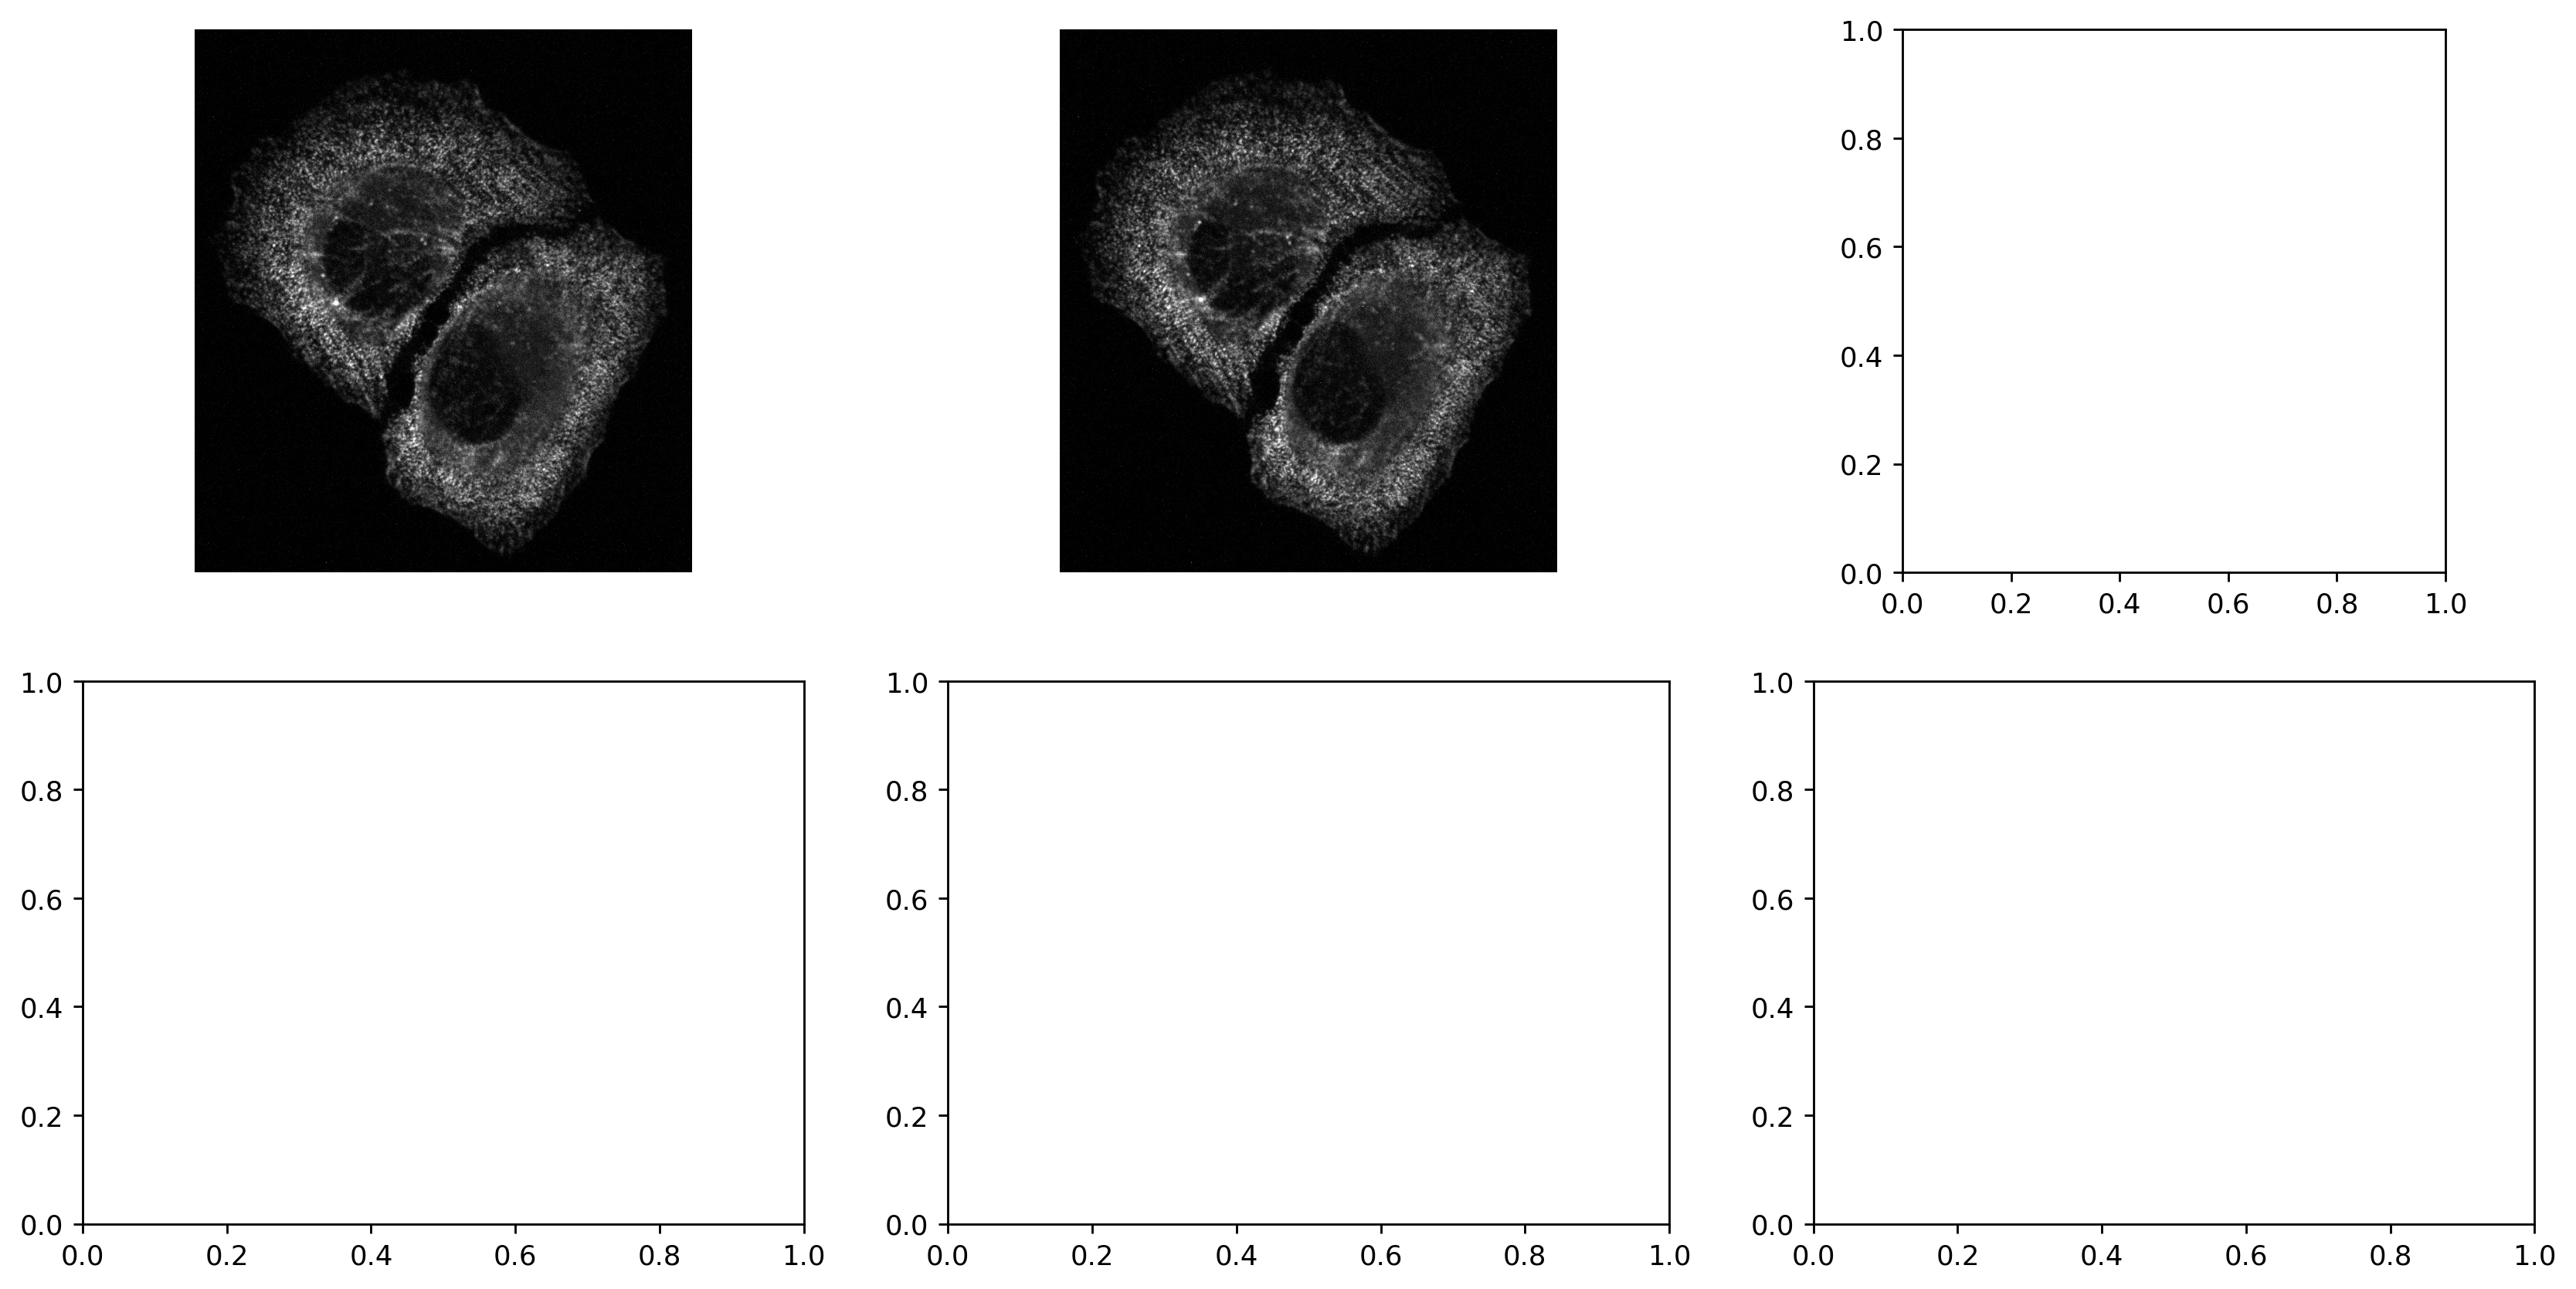

In [8]:
filenames = [x for x in os.listdir(movie_dir) if os.path.isfile(os.path.join(movie_dir, x)) and ('.tif' in x)]


for filenameID in range(1,len(filenames)):
# for filenameID in range(0,1):

    filename = filenames[filenameID]

    movie_processed_data_dir =  os.path.join(processed_data_dir, filename[:-4])
    movie_partitioned_data_dir =  os.path.join(partitioned_data_dir, filename[:-4])
    movie_plot_dir =  os.path.join(plot_dir, filename[:-4])

    if not os.path.isdir(movie_processed_data_dir):
        os.makedirs(movie_processed_data_dir)
    if not os.path.isdir(movie_partitioned_data_dir):
        os.makedirs(movie_partitioned_data_dir)
    if not os.path.isdir(movie_plot_dir):
        os.makedirs(movie_plot_dir)


    img = tifffile.imread(os.path.join(movie_dir,filename))

    smooth_img = ndimage.gaussian_filter(img,sigma=1,mode='nearest',truncate=3)        

    all_values = smooth_img.reshape([img.shape[0]*img.shape[1]*img.shape[2],1])
    mean_threshold = np.mean(all_values)-(0.45)*np.std(all_values)

    num_of_frames = img.shape[0]
    # num_of_frames = 500

    # 
    for frame_ID in range(0,num_of_frames-2):  
    # for frame_ID in range(0,1):
        data_prep_record = pd.DataFrame(columns=['movie_dir','filename','frame_ID','x_c','y_c','rand_angle','rand_tx','rand_ty',
                                                    'x_corner1','x_corner2','x_corner3','x_corner4','y_corner1','y_corner2','y_corner3','y_corner4',
                                                    'movie_partitioned_data_dir','crop_img_filename','movie_plot_dir','plot_filename'])


        train_t0_img = img[frame_ID,:,:].squeeze().astype(np.float)/255
        train_t1_img = img[frame_ID+2,:,:].squeeze().astype(np.float)/255
        nr, nc = train_t0_img.shape


        train_t0_img_smooth = ndimage.gaussian_filter(train_t0_img,sigma=4,mode='nearest',truncate=3)

        seq_im = np.zeros((nr, nc, 3))
        seq_im[..., 0] = train_t0_img
        seq_im[..., 1] = train_t1_img
        seq_im[..., 2] = train_t1_img

        v, u = optical_flow_tvl1(train_t0_img, train_t1_img)
        
        row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')


        fig, ax = plt.subplots(2,3, figsize=(16,8), dpi=256, facecolor='w', edgecolor='k')
        ax[0,0].imshow(train_t0_img, cmap=plt.cm.gray,vmax=1,vmin=0)
        ax[0,0].axis('off')   
        ax[0,1].imshow(train_t1_img, cmap=plt.cm.gray,vmax=1,vmin=0)
        ax[0,1].axis('off')   
        ax[0,2].imshow(seq_im, cmap=plt.cm.gray,vmax=1,vmin=0)
        ax[0,2].axis('off')   

        ax[1,0].imshow(train_t0_img, cmap=plt.cm.gray,vmax=1,vmin=0)



        grid_mask = np.zeros((nr, nc))
        grid_mask[::10,::10]=1
        train_t0_img_grid = train_t0_img_smooth*grid_mask
        list_col_coords = col_coords[train_t0_img_grid>0.1]
        list_row_coords = row_coords[train_t0_img_grid>0.1]
        list_u = u[train_t0_img_grid>0.1]
        list_v = v[train_t0_img_grid>0.1]
        ax[1,0].quiver(list_col_coords,list_row_coords,list_u,-list_v,color='m')
        ax[1,0].axis('off') 

        mag = np.sqrt(u*u+v*v)
        mag[train_t0_img_smooth<=0.1] = np.nan

        cmp_mag = mpl.cm.get_cmap('viridis')  # viridis is the default colormap for imshow
        cmp_mag.set_bad(color='black')

        pos = ax[1,1].imshow(mag,cmap=cmp_mag)        
        fig.colorbar(pos, ax=ax[1,1])
        ax[1,1].axis('off') 

        ang = np.arctan2(u,-v)
        ang[train_t0_img_smooth<=0.1] = np.nan

        cmap = mpl.cm.get_cmap('hsv')  # viridis is the default colormap for imshow
        cmap.set_bad(color='white')

        pos_2 = ax[1,2].imshow(ang, vmax=np.pi,vmin=-np.pi, cmap=cmap)
        fig.colorbar(pos_2, ax=ax[1,2])
        ax[1,2].axis('off') 

        plot_filename = 'plot_flow_t'+str(frame_ID).zfill(4)+'.png'
        fig.savefig(os.path.join(movie_plot_dir,plot_filename),bbox_inch='tight')
        plt.close(fig) 
        
        


In [7]:
num_of_frames

61